In [1]:

from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import init
import torch.nn.functional as F
import functools
import numpy as np
import torchvision
from torchvision import transforms, datasets, models
import os
import time

from torchsummary import summary

from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

Heat map을 만들때 batch_size = 1로 해야 만들 수 있음

In [60]:
# Training settings
batch_size = 1

In [61]:
#%% 이걸 사용하자
# t_image_size=224
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

data_dir = '/media/lee/E61C94F21C94BECD/place_dataset/Places2/data_256/50'
# data_dir = '/media/lee/E61C94F21C94BECD/place_dataset/Places2/data_class50/'


train_image_datasets = torchvision.datasets.ImageFolder(os.path.join(data_dir),
                                     transform = transform_train)
val_image_datasets = torchvision.datasets.ImageFolder(os.path.join(data_dir),
                                     transform = transform_val)
test_image_datasets = torchvision.datasets.ImageFolder(os.path.join(data_dir),
                                     transform = transform_test)


dataset_size = len(train_image_datasets)
print('total size:', dataset_size)
class_names_train = train_image_datasets.classes
class_names_val = val_image_datasets.classes
class_names_test = test_image_datasets.classes
# print(class_names)
print('# of train class: ', len(class_names_train))
print('# of valid class: ', len(class_names_val))
print('# of test class : ', len(class_names_test))
## SPLIT DATASET
train_split= 0.50
validate_split = 0.20
test_split = 0.30
train_size = int(train_split * dataset_size)
validation_size = int(validate_split * dataset_size)
test_size = int(dataset_size - train_size - validation_size)

# ########### CURRENTLY DOING THIS, WHICH WORKS ###########

indices = list(range(dataset_size))
np.random.shuffle(indices)
train_indices = indices[:train_size]
temp = int(train_size+validation_size)
val_indices = indices[train_size:temp]
test_indices = indices[temp:]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(
    train_image_datasets, batch_size=batch_size, sampler=train_sampler,
    num_workers=4)
valid_loader = torch.utils.data.DataLoader(
    val_image_datasets, batch_size=batch_size, sampler=valid_sampler,
    num_workers=4)
test_loader = torch.utils.data.DataLoader(
    test_image_datasets, batch_size=batch_size, sampler=test_sampler,
    num_workers=4)

dataloaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test' : test_loader
}
image_datasets = {
    'train': train_sampler,
    'valid': valid_sampler,
    'test' : test_sampler
}

dataset_sizes ={
    'train': len(image_datasets['train']),
    'valid': len(image_datasets['valid']),
    'test' : len(image_datasets['test'])
}

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# print('train_class:' len(train_image_datasets.classes))

print('train_size: ',dataset_sizes['train'], '\nvalid_size: ',dataset_sizes['valid'], 
      '\ntest_size : ',dataset_sizes['test'])
# class_names = image_datasets['train'].classes
# print(class_names)
# print('len class: ', len(class_names))



total size: 247089
# of train class:  50
# of valid class:  50
# of test class :  50
train_size:  123544 
valid_size:  49417 
test_size :  74128


In [62]:
from ResidualUnit import ResidualBlock
from ASPP_place_edit import ASPP_places
# from attention_module import Attention_step1

In [63]:
class Attention_place(nn.Module):
    def __init__(self):
        super(Attention_place, self).__init__()
        self.begin_residual_blocks = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)
        )#56x56
        self.trunk_first_conv = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64, kernel_size=1)
        )#56x56
        self.trunk = nn.Sequential(
            ResidualBlock(64, 256, 1),
            ResidualBlock(256, 256, 1)
        )#56x56
        self.trunk_last_conv = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size = 1)
        )#56x56
        self.trunk_residual = nn.Sequential(
            nn.Conv2d(64,256,1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
#             nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1)
        )
#         resnet = ResNet18()
#         self.num_classes = len(class_names)
#         self.resnet = nn.Sequential(*list(resnet.children())[:-2])#8x8

        self.aspp = ASPP_places()
        self.mask_first_conv = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=1, stride = 2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )#28x28
        self._last_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1, stride = 2),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 2048, kernel_size=1, stride = 2),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1)
        )#7x7
        
        
        self.mpool = nn.Sequential(
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=7, stride=1)
        )
        self.fc = nn.Linear(2048, len(class_names_train))
    def forward(self, x):
        h = int(x.size()[2] / 4)
        w = int(x.size()[3] / 4)
#         print('h:',h, 'w:',w)
        x1 = self.begin_residual_blocks(x)#56x56
#         print(x1.shape)
#         print(x1.shape)
#################trunk_part#################
        out_trunk1 = self.trunk_first_conv(x1)#56x56
        out_trunk2 = self.trunk(out_trunk1)#56x56
        out_trunk3 = self.trunk_last_conv(out_trunk2)#56x56
#         out_trunk = F.upsample(out_trunk, size=(h,w), mode="bilinear")#56x56x256
        out_trunk4 = out_trunk3 + self.trunk_residual(x1)#56x56
#         out_trunk = F.softmax(out_trunk)
#################trunk_part#################        

#################mask_part#################
        feature_map = self.mask_first_conv(x1)#28x28x256
        mask1 = self.aspp(feature_map)#28x28x256
#         print(mask.shape)
        mask2 = F.upsample(mask1, size=(h, w), mode="bilinear") #56x56x256
#         mask = F.softmax(mask)
#################mask_part#################
        out1 = (1 + mask2) * out_trunk4 #56x56x256
#         print(out.shape)
        out2 = self._last_conv(out1)#7x7x512
#         print(out.shape)
        out3 = self.mpool(out2)#1x1x512
#         print(out.shape)
        out4 = out3.view(out3.size(0),-1)
#         print(out.shape)
        out = self.fc(out4)

        return out, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4
        

In [64]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:         # Conv weight init
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:  # BatchNorm weight init
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [65]:
model = Attention_place()

In [66]:
model.apply(weights_init)

Attention_place(
  (begin_residual_blocks): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (trunk_first_conv): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (trunk): Sequential(
    (0): ResidualBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, e

In [67]:
# device = torch.device('cuda:0')
# torch.cuda.set_device(device)
# model.cuda()
# summary(model,(3,224,224))

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA, model")
    model.cuda() #after second other epoch model
summary(model,(3,224,224))

Using CUDA, model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]           4,160
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]           4,096
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14 

In [ ]:
writer = SummaryWriter()

In [ ]:
def train_model(model, scheduler, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        since1 = time.time()
        # Each epoch has a training and validation phase
        train_batches = len(dataloaders['train'])
        for phase in ['train','valid']:
            
            print("lr:", optimizer.param_groups[0]['lr'])
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            for i, data in enumerate(dataloaders[phase]):
                if i % 100 == 0:
                    print("\rTraining batch {}/{}".format(i, len(dataloaders[phase])), end='', flush=True)
                # Use half training dataset
                if i >= len(dataloaders[phase]):
                    break    
                inputs, labels = data
                inputs, labels = Variable(inputs.cuda()),Variable(labels.cuda())

                optimizer.zero_grad()

                    # forward
                    # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    out, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4 = model(inputs)
                    _, preds = torch.max(out, 1)
                    loss = criterion(out, labels)
#                     print(loss)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                writer.add_scalar('data/train_loss_places', epoch_loss, epoch)
                writer.add_scalar('data/train_acc_places', epoch_acc, epoch)
            else:
                writer.add_scalar('data/val_loss_places', epoch_loss, epoch)
                writer.add_scalar('data/val_acc_places', epoch_acc, epoch)
            for name, param in model.named_parameters():
                writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch)
            time_elapsed1 = time.time() - since1
            print('\rEpoch process in {:.0f}m {:.0f}s'.format(
            time_elapsed1 // 60, time_elapsed1 % 60))
            print('{} Loss: {:.4f} Acc: {:.4f} lr: {:.8f}'.format(phase, epoch_loss, 
                                                                  epoch_acc*100, optimizer.param_groups[0]['lr']))
#             csvfile = open(os.path.join('./csv/resnet18/', '20190102resnet18_64_data_15_places_{}{}_class{}_epoch{}.csv'.format(optimizer_name, learning_rate, len(class_names), num_epochs)), 'a', newline='')
#             csv_writer = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
#             csv_writer.writerow(['class', len(class_names), 'epoch', epoch, phase, epoch_loss, epoch_acc])
#             csvfile.close()
#             deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} at {}'.format(best_acc, best_epoch+1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
import copy
lr = 0.001  # 0.1
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.0001)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
total_epoch = 100
model_train = train_model(model, scheduler, criterion, optimizer, num_epochs=total_epoch)
torch.save(model_train.state_dict(), './Trained/place_50_adam_0307.pt')

In [ ]:
### test each class accuracy###
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs,1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%'% (classes[i], 100 * class_correct[i] / class_total[i]))

In [24]:
############################train more

 # load the pre-trained weights
model_file = 'place_50_adam_0307.pt'
path = '/home/lee/Research/4.Contents_work/Trained/' + model_file
model = Attention_place()
model.load_state_dict(torch.load(path))
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA, model_test")
    model.cuda() #after second other epoch model

Using CUDA, model_test


In [71]:
# Get a batch of training data
inputs1, classes = next(iter(dataloaders['train']))

(3, 224, 224)
(224, 224, 3)


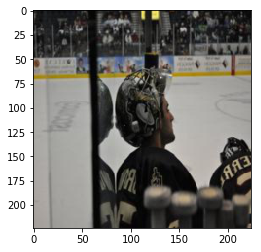

In [72]:
images1 = inputs1[0].numpy()
print(images1.shape)
images1 = np.transpose(images1,[1,2,0])
print(images1.shape)
# plt.subplot(121)
plt.imshow(images1)

In [73]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [74]:
layer_=model._modules.get('_last_conv')

activated_features = SaveFeatures(layer_)

In [75]:
model.eval()
inputs1 = Variable(inputs1.cuda())
out, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4 = model(inputs1)
pred_probabilities = F.softmax(out).data.squeeze()
activated_features.remove()

/home/lee/anaconda3/envs/pytorch1/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [83]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [84]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [85]:
weight_softmax_params

[Parameter containing:
 tensor([[ 0.0020, -0.0062,  0.0019,  ...,  0.0084,  0.0004,  0.0046],
         [-0.0184, -0.0188,  0.0216,  ...,  0.0101, -0.0071,  0.0041],
         [-0.0105, -0.0201, -0.0062,  ...,  0.0187, -0.0172,  0.0071],
         ...,
         [-0.0024, -0.0156,  0.0048,  ..., -0.0172,  0.0107,  0.0180],
         [-0.0079, -0.0080,  0.0140,  ..., -0.0053, -0.0123, -0.0096],
         [ 0.0114,  0.0077, -0.0088,  ..., -0.0093, -0.0067, -0.0215]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-0.0021, -0.0133,  0.0076, -0.0143, -0.0179,  0.0087, -0.0165, -0.0205,
          0.0162, -0.0114,  0.0086,  0.0025,  0.0072,  0.0077,  0.0069,  0.0083,
         -0.0067,  0.0153,  0.0133, -0.0084,  0.0139,  0.0027,  0.0093, -0.0104,
          0.0072, -0.0138,  0.0005, -0.0151,  0.0149,  0.0126,  0.0128, -0.0215,
          0.0087,  0.0095,  0.0059,  0.0007, -0.0089, -0.0125,  0.0098,  0.0134,
          0.0183,  0.0154,  0.0174, -0.0053,  0.0182,  0.0058, 

In [86]:
from torch import topk
class_idx = topk(pred_probabilities,1)[1].int()
print(class_idx)

tensor([47], device='cuda:0', dtype=torch.int32)


In [87]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx)

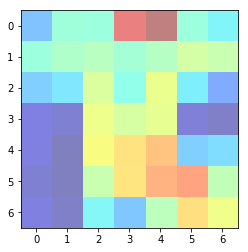

In [81]:
# from matplotlib.pyplot import imshow
plt.imshow(overlay[0], alpha=0.5, cmap='jet')

/home/lee/anaconda3/envs/pytorch1/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/lee/anaconda3/envs/pytorch1/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


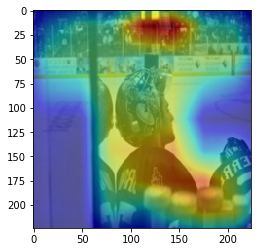

In [82]:
import skimage.transform
plt.imshow(images1)
plt.imshow(skimage.transform.resize(overlay[0], inputs1.shape[2:4]), alpha=0.5, cmap='jet');

In [88]:
def imshow(inp, name):
    """Imshow for Tensor."""
    inp = inp.detach().cpu().numpy()
    inp = np.transpose(inp,[1,2,0])#widthxheightxchannels

    n_features = inp.shape[-1]
    size = inp.shape[0]
    images_per_row = 16
    n_cols = n_features // images_per_row
    
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = inp[:,:, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size : (col +1) * size, 
                        row * size : (row + 1) * size]=channel_image
    scale = 1./size
    plt.figure(figsize = (scale * display_grid.shape[1],
                         scale * display_grid.shape[0]))
    plt.title(name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')

/home/lee/anaconda3/envs/pytorch1/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/lee/anaconda3/envs/pytorch1/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/lee/anaconda3/envs/pytorch1/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


ValueError: axes don't match array

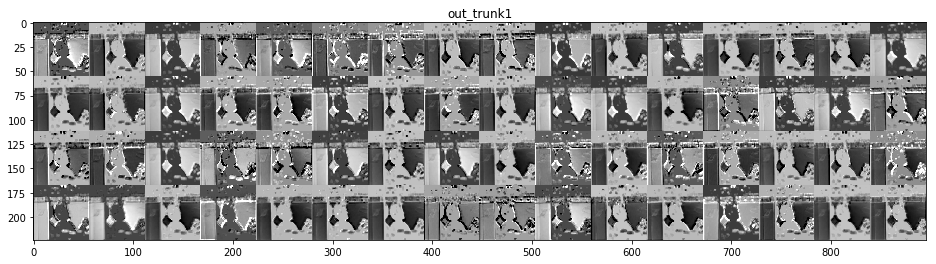

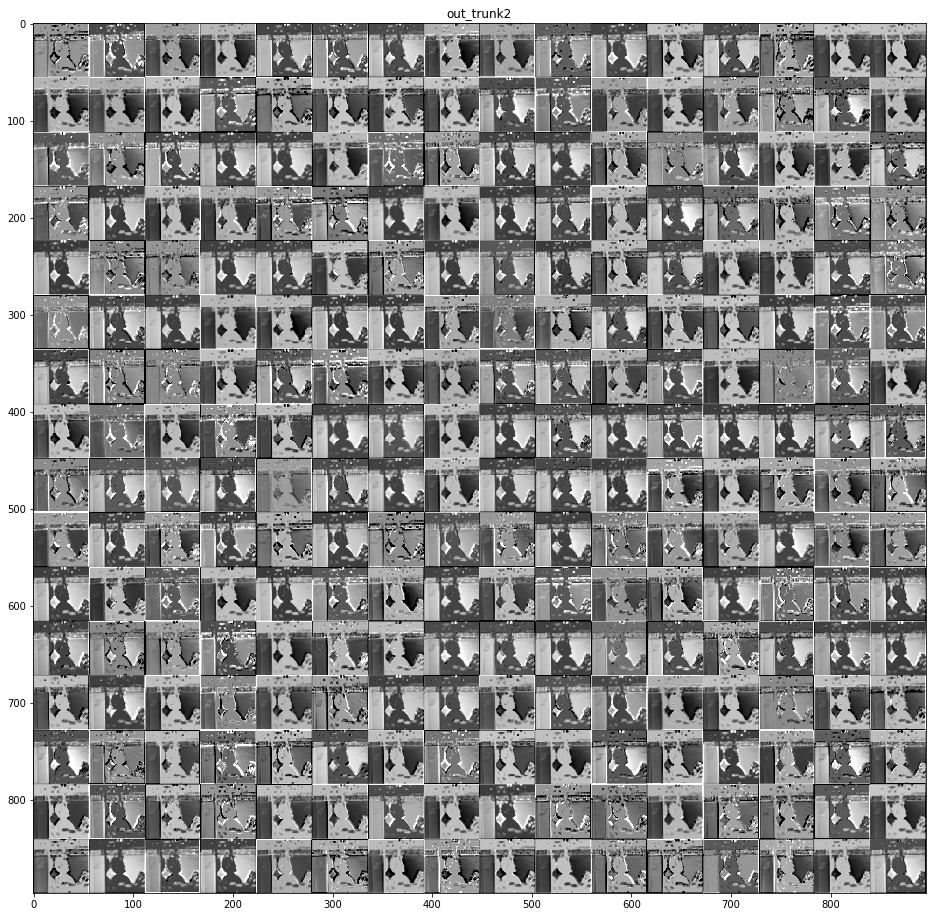

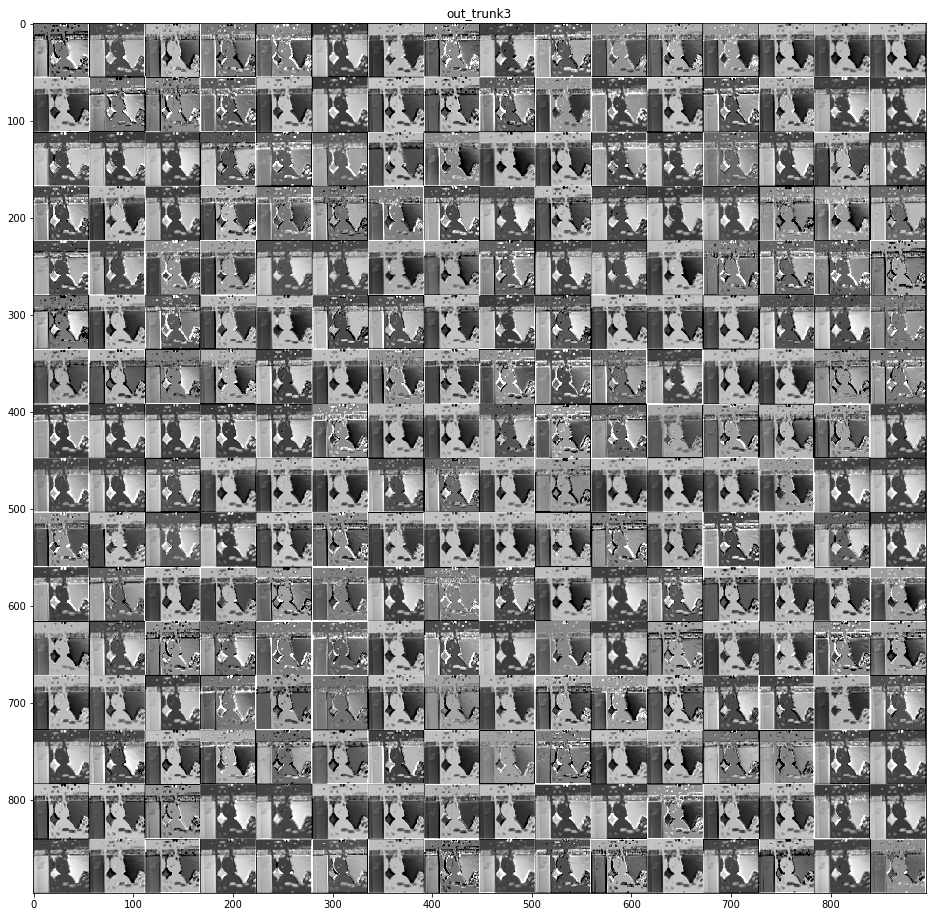

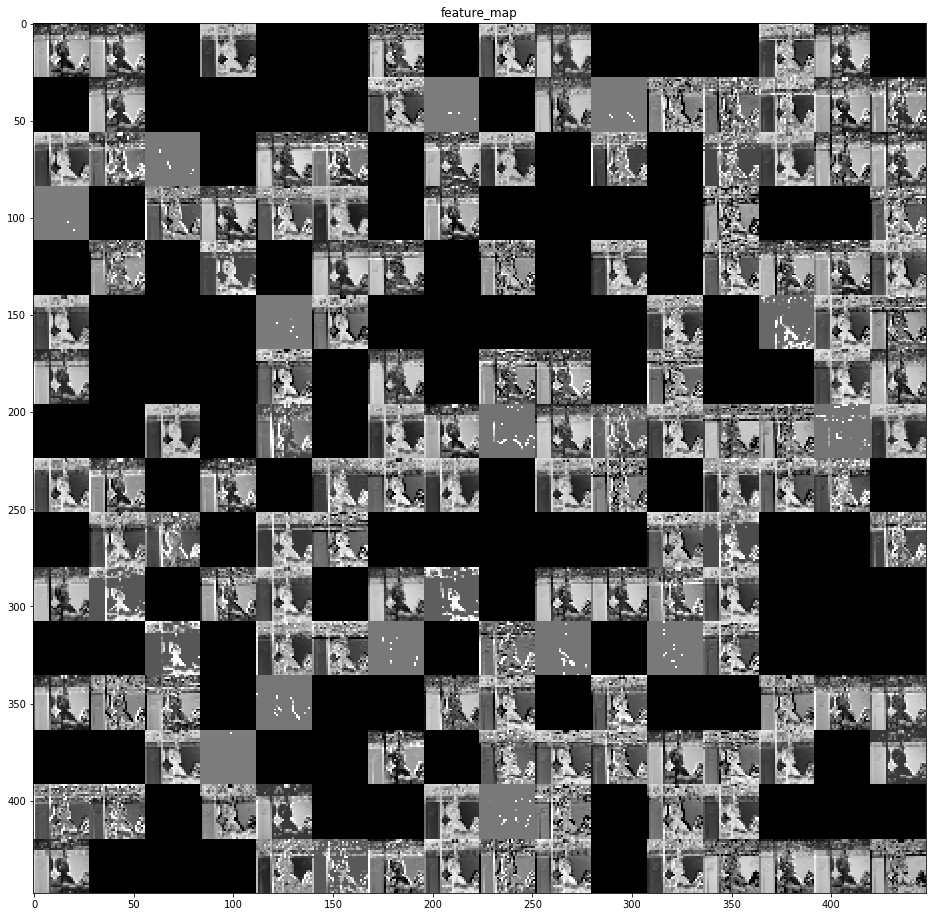

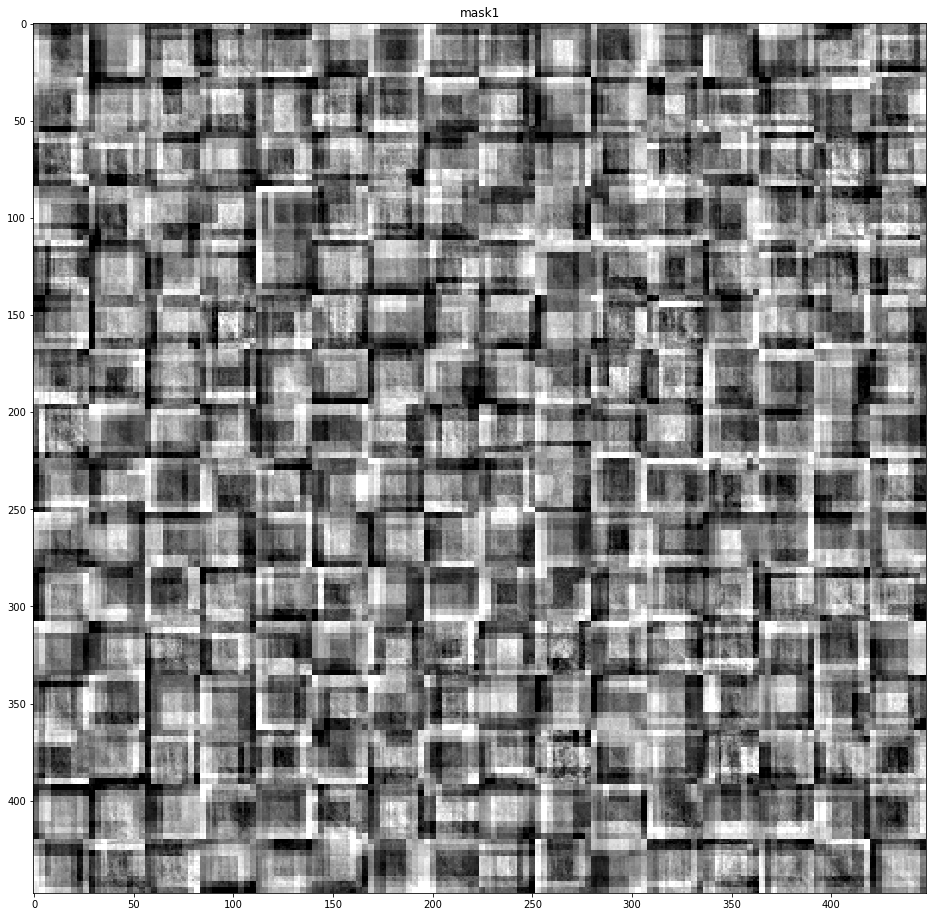

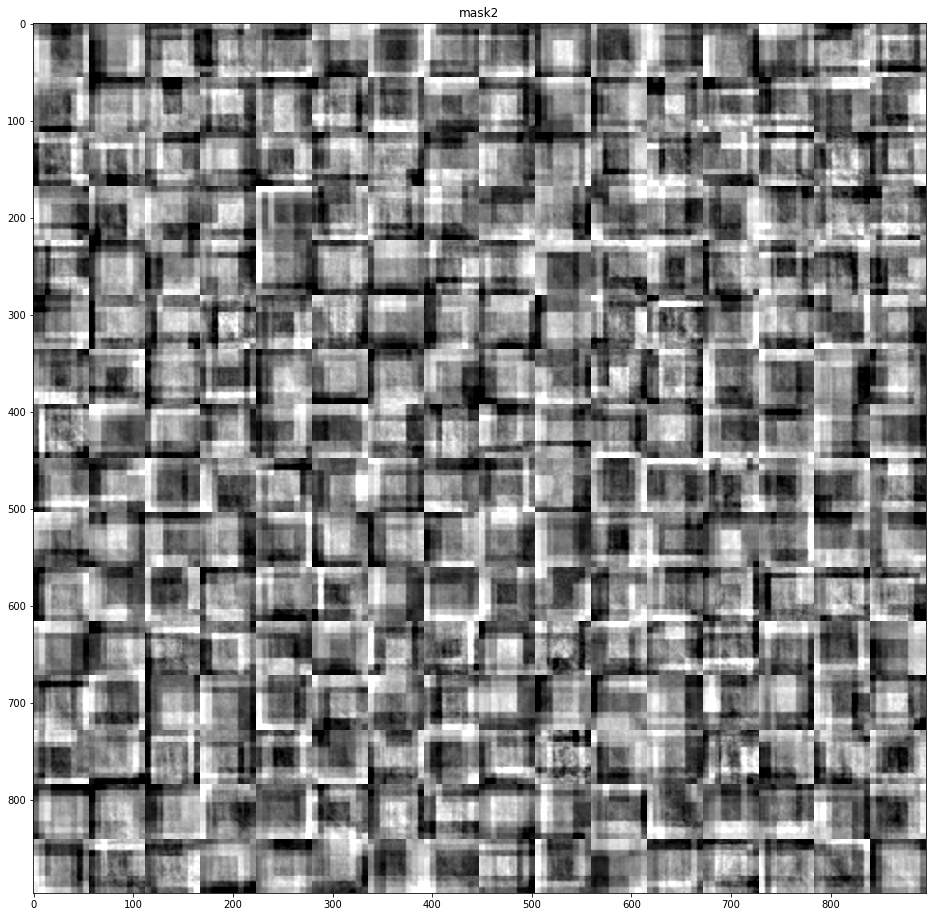

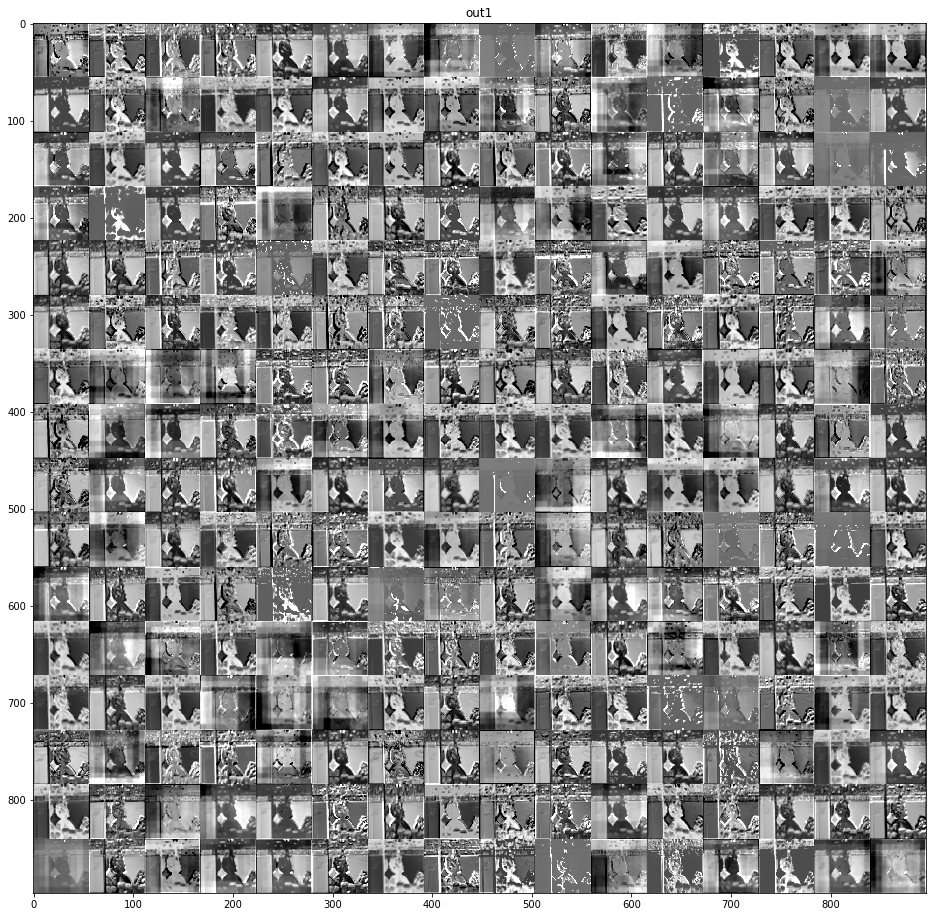

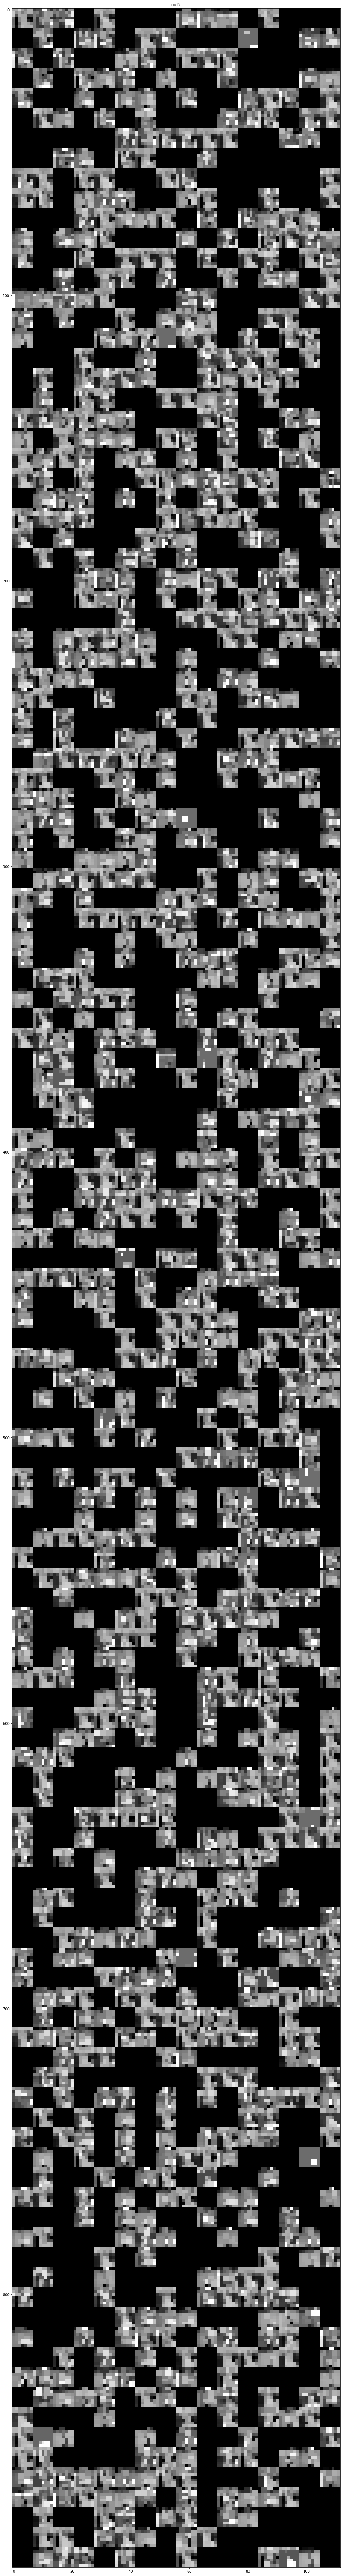

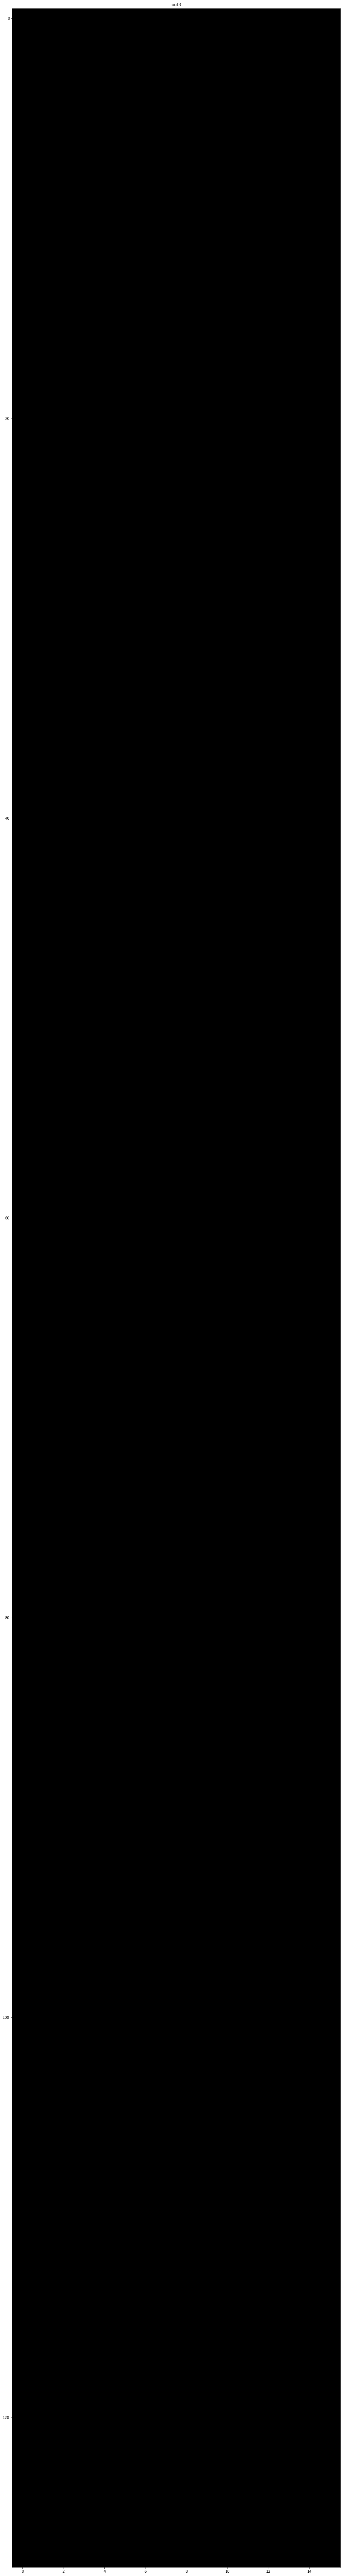

In [89]:
inputs1 = Variable(inputs1.cuda())

out, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4= model(inputs1)

conv1 = out_trunk1[0]
conv2 = out_trunk2[0]
conv3 = out_trunk3[0]
conv4 = feature_map[0]
conv5 = mask1[0]
conv6 = mask2[0]
conv7 = out1[0]
conv8 = out2[0]
conv9 = out3[0]
conv10 = out4[0]

name = "out_trunk1"
imshow(conv1, name)
name = "out_trunk2"
imshow(conv2, name)
name = "out_trunk3"
imshow(conv3, name)
name = "feature_map"
imshow(conv4, name)
name = "mask1"
imshow(conv5, name)
name = "mask2"
imshow(conv6, name)
name = "out1"
imshow(conv7, name)
name = "out2"
imshow(conv8, name)
name = "out3"
imshow(conv9, name)
name = "out4"
imshow(conv10, name)
# print("flatten")
# imshow(conv12)

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [ ]:
model.eval()
inputs1 = Variable(inputs1.cuda())
out, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4 = model(inputs1)
pred_probabilities = F.softmax(out).data.squeeze()
activated_features.remove()

In [ ]:
# Get a batch of training data
inputs1, classes = next(iter(dataloaders['train']))

In [ ]:
images1 = inputs1[0].numpy()
print(images1.shape)
images1 = np.transpose(images1,[1,2,0])
print(images1.shape)
# plt.subplot(121)
plt.imshow(images1)

In [ ]:
layer_=model._modules.get('_last_conv')
activated_features = SaveFeatures(layer_)

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
criterion = nn.CrossEntropyLoss()
def test(model3, criterion):
    

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for phase in ['test','valid']:
            print(phase)
            batch_time = AverageMeter()
            losses = AverageMeter()
            top1 = AverageMeter()
            top5 = AverageMeter()
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                if model3.cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                inputs, labels = Variable(inputs, volatile=True), Variable(labels)

                # compute output
                outputs, x1, out_trunk1, out_trunk2, out_trunk3, feature_map, mask1, mask2, out1, out2, out3, out4 = model(inputs)
                loss = criterion(outputs, labels)

                # measure accuracy and record loss
                acc1, acc5 = accuracy(outputs, labels, topk=(1, 3))
                losses.update(loss.item(), inputs.size(0))
                top1.update(acc1[0], inputs.size(0))
                top5.update(acc5[0], inputs.size(0))

                # measure elapsed time
                batch_time.update(time.time() - end)
                end = time.time()

                if i % 10 == 0:
                    print('Test: [{0}/{1}]\t'
                          'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                          'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                          'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                          'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                           i, len(dataloaders[phase]), batch_time=batch_time, loss=losses,
                           top1=top1, top5=top5))
            
            print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
                  .format(top1=top1, top5=top5))
            

    return top1.avg

In [ ]:
test(model,criterion)